In [403]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
import pandas as pd
df=pd.read_csv('healthcare.csv')

In [404]:
#As there are a lot of null data, i drop them.
df=df.dropna()

In [405]:
#Creating different dataframes for mortality and Incidence
Incidence_df=df[df['Type']=='Incidence']
Mortality_df=df[df['Type']=='Mortality']

In [406]:
#As i want to plot a summary, i need to sum all values by age
start_col = 'Age_0_to_4'
end_col = 'Age_85+'
start_idx = Incidence_df.columns.get_loc(start_col)
end_idx = Incidence_df.columns.get_loc(end_col)

selected_columns = Incidence_df.columns[start_idx:end_idx + 1]
Incidence_dict = Incidence_df[selected_columns].sum().to_dict()

selected_columns = Mortality_df.columns[start_idx:end_idx + 1]
Mortality_dict = Mortality_df[selected_columns].sum().to_dict()

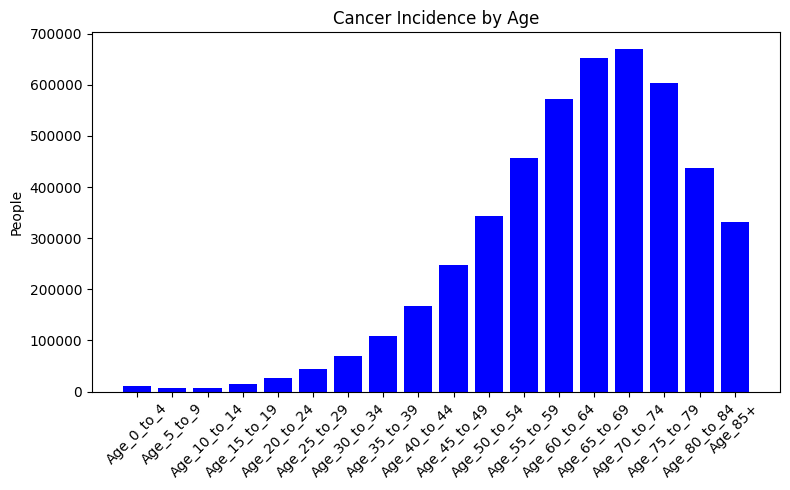

In [407]:
#Sum of incidence cases (for all cancers) by age
keys = list(Incidence_dict.keys())
values = list(Incidence_dict.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='blue')
plt.ylabel('People')
plt.title('Cancer Incidence by Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

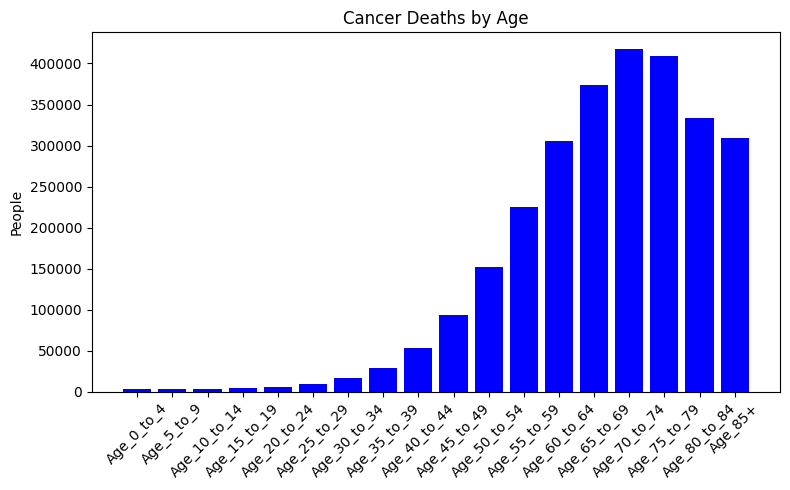

In [408]:
#Sum of all death (for all cancers) by age
keys = list(Mortality_dict.keys())
values = list(Mortality_dict.values())

plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='blue')
plt.ylabel('People')
plt.title('Cancer Deaths by Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [409]:
filter = (df["Cancer_Type"] == "Uterine cancer") & (df["Type"] == "Mortality") 
uterine_df1= df[filter]
uterine_df1=uterine_df1.dropna()

filter = (df["Cancer_Type"] == "Uterine cancer") & (df["Type"] == "Incidence") 
uterine_df2= df[filter]
uterine_df2=uterine_df2.dropna()

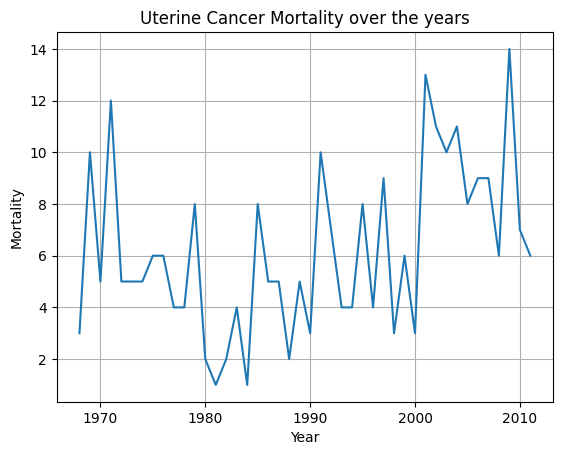

In [410]:
#Plot Uterine Cancer mortality for an example age
plt.plot(uterine_df1["Year"], uterine_df1['Age_45_to_49'])
plt.xlabel("Year")
plt.ylabel("Mortality")
plt.title("Uterine Cancer Mortality over the years")
plt.grid(True)
plt.show()

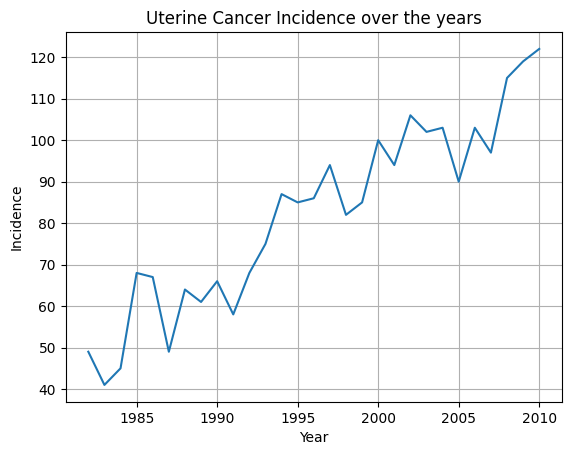

In [411]:
#Plot Uterine Cancer Incidence for an example age
plt.plot(uterine_df2["Year"], uterine_df2['Age_45_to_49'])
plt.xlabel("Year")
plt.ylabel("Incidence")
plt.title("Uterine Cancer Incidence over the years")
plt.grid(True)
plt.show()

In [412]:
#Now we want to evaluate incidence and mortality on the same graphic, so we need normalization. 
#I also sum cases for all ages
scaler=MinMaxScaler()
uterine_df1["Sum"] = uterine_df1.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
uterine_df1['Normalized_sum']=scaler.fit_transform(uterine_df1[['Sum']])

uterine_df2["Sum_Death"] = uterine_df2.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
uterine_df2['Normalized_sum_death']=scaler.fit_transform(uterine_df2[['Sum_Death']])

In [413]:
#Merging only for years that we have on both dataframe
uterine_df1 = pd.merge(uterine_df1, uterine_df2[['Year', 'Sum_Death', 'Normalized_sum_death']], on='Year', how='inner')

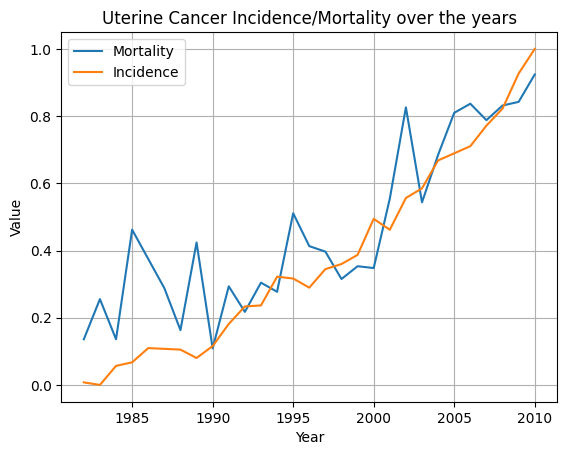

In [414]:
#Comparing normalized values for Incidence and Mortality of uterine cancer over the years
plt.plot(uterine_df1["Year"], uterine_df1['Normalized_sum'], label="Mortality")
plt.plot(uterine_df1["Year"], uterine_df1['Normalized_sum_death'], label="Incidence")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Uterine Cancer Incidence/Mortality over the years")
plt.grid(True)
plt.show()


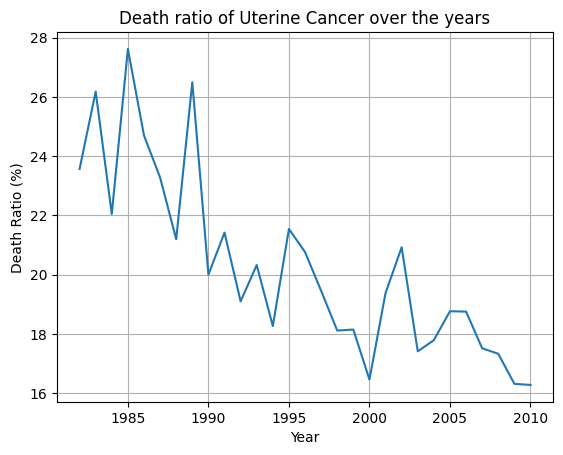

In [415]:
#Evaluating % values of death ratio of uterine cancer over the years
uterine_df1['Death_Ratio']=uterine_df1['Sum']/uterine_df1['Sum_Death']
plt.plot(uterine_df1['Year'], uterine_df1['Death_Ratio']*100 )
plt.xlabel('Year')
plt.ylabel('Death Ratio (%)')
plt.title('Death ratio of Uterine Cancer over the years')
plt.grid(True)
plt.show()

In [416]:
#Age groups clusterization. We'll make a long table using melt, then pivot to have value for every age across the years.

age_columns = uterine_df2.columns[4:] 

df_melted = uterine_df2.melt(
    id_vars=['Year', 'Sex', 'Type', 'Cancer_Type'],
    value_vars=age_columns,
    var_name='AgeGroup',
    value_name='Value'
)

In [417]:
df_age_matrix = df_melted.pivot_table(
    index='AgeGroup',
    columns=['Year', 'Sex', 'Type', "Cancer_Type"],
    values='Value',
    fill_value=0
)

In [418]:
#Values Standardization
scaler = StandardScaler()
Standardized_age_uterine= scaler.fit_transform(df_age_matrix)
Standardized_age_uterine = pd.DataFrame(Standardized_age_uterine, index=df_age_matrix.index, columns=df_age_matrix.columns.drop('Cluster', errors='ignore'))

In [419]:
#I don't need the last rows for this kind of work
Standardized_age_uterine = Standardized_age_uterine.drop(Standardized_age_uterine.index[[19,20]])

In [420]:
Standardized_age_uterine

Year,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
Sex,Female,Female,Female,Female,Female,Female,Female,Female,Female,Female,...,Female,Female,Female,Female,Female,Female,Female,Female,Female,Female
Type,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,...,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence
Cancer_Type,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,...,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer
AgeGroup,,,,,,,,,,,,,,,,,,,,,
Age_0_to_4,-0.452751,-0.454179,-0.451424,-0.453806,-0.453386,-0.452322,-0.453460,-0.453543,-0.453943,-0.453290,...,-0.454767,-0.455666,-0.454937,-0.455306,-0.454932,-0.452354,-0.453579,-0.454976,-0.453740,-0.454301
Age_10_to_14,-0.452751,-0.454179,-0.451424,-0.453806,-0.453386,-0.452322,-0.453460,-0.453543,-0.453943,-0.453290,...,-0.454767,-0.455666,-0.454937,-0.455306,-0.454932,-0.454905,-0.453579,-0.454976,-0.453740,-0.454301
Age_15_to_19,-0.452751,-0.454179,-0.451424,-0.439805,-0.453386,-0.447900,-0.453460,-0.453543,-0.453943,-0.449229,...,-0.454767,-0.455666,-0.452137,-0.455306,-0.454932,-0.454905,-0.453579,-0.454976,-0.451533,-0.454301
Age_20_to_24,-0.437611,-0.449062,-0.446717,-0.449139,-0.448966,-0.447900,-0.453460,-0.453543,-0.445157,-0.453290,...,-0.454767,-0.455666,-0.446538,-0.450042,-0.449752,-0.454905,-0.451141,-0.450247,-0.453740,-0.454301
Age_25_to_29,-0.427518,-0.438828,-0.442010,-0.439805,-0.444546,-0.452322,-0.449015,-0.439780,-0.453943,-0.445168,...,-0.445484,-0.441326,-0.443739,-0.444778,-0.447162,-0.444701,-0.438950,-0.436060,-0.447118,-0.439497
Age_30_to_34,-0.366959,-0.408127,-0.442010,-0.421138,-0.409186,-0.416946,-0.440124,-0.412254,-0.423193,-0.428925,...,-0.417637,-0.424119,-0.435340,-0.418457,-0.416082,-0.416639,-0.421883,-0.395863,-0.411802,-0.428922


In [421]:
#Use KMeans to cluster ages using artifical Intelligence. The machine learning process identify ages with similar behavior.
#This is very useful in public health. 
kmeans = KMeans(n_clusters=4, random_state=42)
Standardized_age_uterine['Cluster'] = kmeans.fit_predict(Standardized_age_uterine)
df_clusters = Standardized_age_uterine.reset_index()[['AgeGroup', 'Cluster']].sort_values('Cluster')
df_clusters

Year,AgeGroup,Cluster
Sex,,
Type,,
Cancer_Type,,
7,Age_40_to_44,0
8,Age_45_to_49,0
17,Age_85+,0
16,Age_80_to_84,0
12,Age_60_to_64,1
14,Age_70_to_74,1
10,Age_55_to_59,1


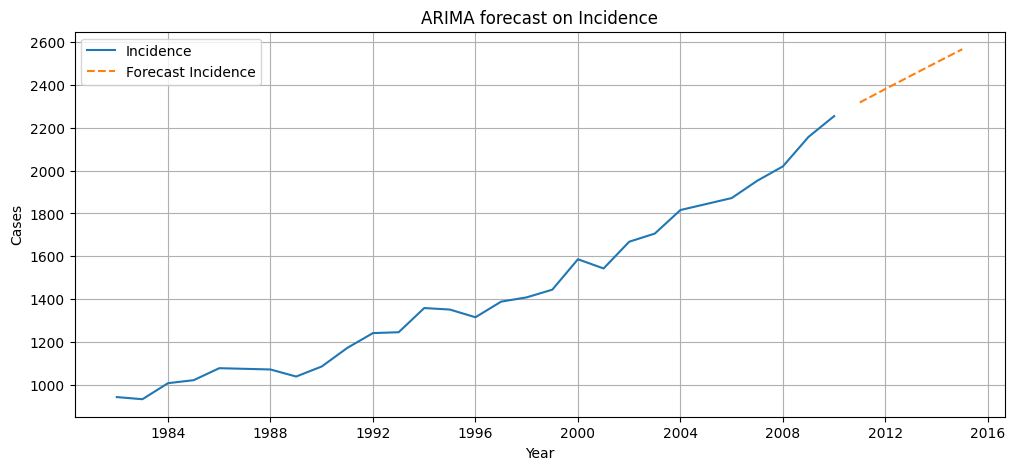

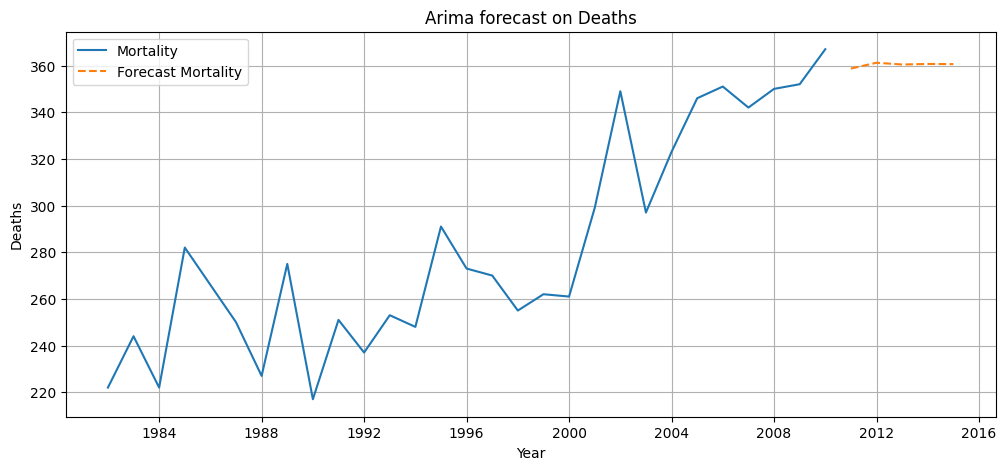

In [422]:
uterine_df1['Year'] = pd.to_datetime(uterine_df1['Year'], format='%Y')
uterine_df1.set_index('Year', inplace=True)
uterine_df1.index = uterine_df1.index.to_period('Y') 

# Temporal series
incidence_ts = uterine_df1['Sum_Death']
mortality_ts = uterine_df1['Sum']

# ARIMA Incidence
model_inc = ARIMA(incidence_ts, order=(1, 1, 1))
result_inc = model_inc.fit()
forecast_inc = result_inc.forecast(steps=5)

# ARIMA Mortality
model_mort = ARIMA(mortality_ts, order=(1, 1, 1))
result_mort = model_mort.fit()
forecast_mort = result_mort.forecast(steps=5)

# Convert index to timestamp
incidence_ts_plot = incidence_ts.copy()
incidence_ts_plot.index = incidence_ts_plot.index.to_timestamp()

forecast_inc_plot = forecast_inc.copy()
forecast_inc_plot.index = forecast_inc_plot.index.to_timestamp()

mortality_ts_plot = mortality_ts.copy()
mortality_ts_plot.index = mortality_ts_plot.index.to_timestamp()

forecast_mort_plot = forecast_mort.copy()
forecast_mort_plot.index = forecast_mort_plot.index.to_timestamp()

# Plot Incidence
plt.figure(figsize=(12, 5))
plt.plot(incidence_ts_plot, label='Incidence')
plt.plot(forecast_inc_plot, label='Forecast Incidence', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Cases")
plt.title('ARIMA forecast on Incidence')
plt.legend()
plt.grid(True)
plt.show()

# Plot Mortality
plt.figure(figsize=(12, 5))
plt.plot(mortality_ts_plot, label='Mortality')
plt.plot(forecast_mort_plot, label='Forecast Mortality', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.title('Arima forecast on Deaths')
plt.legend()
plt.grid(True)
plt.show()

#As it is completely normal to have non stationary warning on ARIMA, i ignore it
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
